### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import optuna.visualization as vis

from stable_baselines3 import PPO, A2C, SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import StochasticExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory
from mbt_gym.agents.SbAgent import SbAgent

### Create market making environment

In [4]:
sigma= 0.1 # constant "volatility" of mid-price process
arrival_rate = 100 # lambda 
fill_exponent = 1 # kappa
alpha = 0.001 # terminal inventory penalty (fees of market orders and walking the book)
phi = 0.5 # running inventory penalty parameter

terminal_time = 1.0 # time [0,1]
initial_inventory = (-3,4) # initial inventory will be random integer from {-3,-2,...,2,3}
initial_price = 100

n_steps = int(10 * terminal_time * arrival_rate)
step_size = 1/n_steps

In [5]:
def get_cj_env(num_trajectories:int = 1):
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = AlphaAdverseSelectionMidpriceModel(step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = StochasticExponentialFillFunction( 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = CjMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
num_trajectories = 1000
env = get_cj_env(num_trajectories)
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [7]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/RL-learning-CJ/"
best_model_path = "./SB_models/RL-best-CJ"

### Train PPO Model

In [8]:
tensorboard_logdir = "./tensorboard/"
best_model_path = "./SB_models/"
n_eval_episodes = 50
eval_freq = 500_000
total_timesteps = 20_000_000

In [9]:
PPO_tensorboard_logdir = tensorboard_logdir + "PPO-learning-CJ/"
PPO_best_model_path = best_model_path + "PPO-best-CJ"
PPO_callback_params = dict(eval_env=sb_env, n_eval_episodes=n_eval_episodes, best_model_save_path=PPO_best_model_path, eval_freq = eval_freq,
deterministic=True)

PPO_callback = EvalCallback(**PPO_callback_params)
ppo_model = PPO("MlpPolicy", sb_env, verbose=0, tensorboard_log=PPO_tensorboard_logdir, n_steps= int(n_steps), batch_size= int(n_steps * num_trajectories / 10))

In [10]:
ppo_model.learn(total_timesteps=total_timesteps, callback = PPO_callback)

### Plotting results

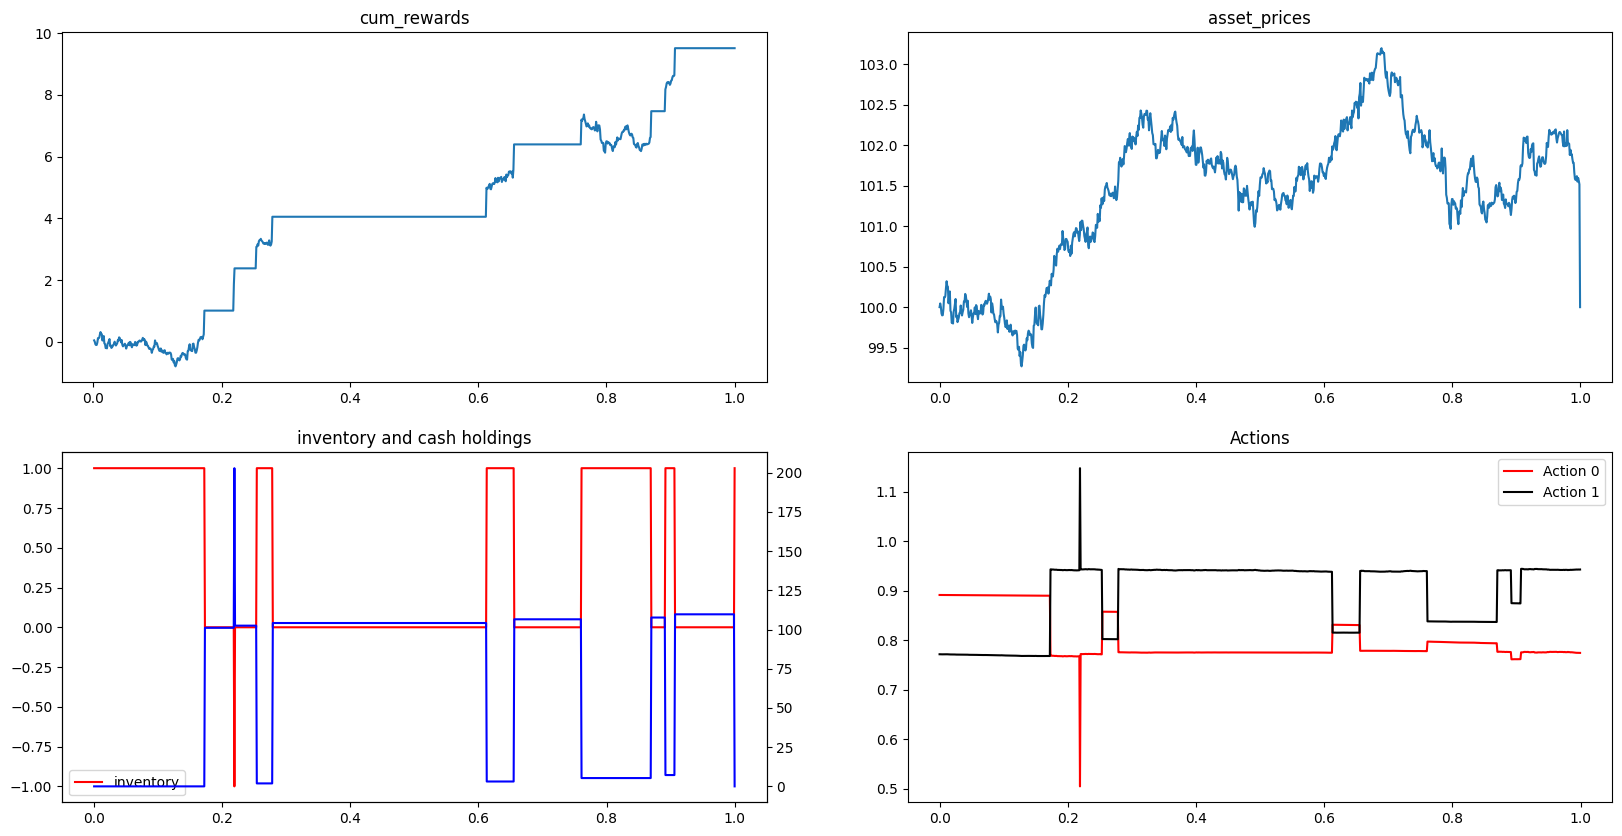

In [11]:
ppo_agent = SbAgent(ppo_model)
plot_trajectory(sb_env, ppo_agent)